# **Profundizando en el problema de clasificación**

En este cuaderno se estudian otras técnicas avanzadas para abordar el problema de clasificiación. Para ello, dividimos el documento en tres secciones.

A lo largo de la sección *Configuración inicial*, se cargan y preprocesan los datos del problema tal y como lo hicimos en el cuaderno principal. A continuación, en la sección *Técnicas para la generación de datos sintéticos*, se emplean métodos para aumentar las instancias de nuestro conjunto de entrenamiento, usando posteriormente técnicas de aprendizaje semi-supervisado con las que realizar la clasificación final. Por último, en la sección *Modelos preentrenados*, probamos otro enfoque, adaptando la red ResNet18 ya entrenada a nuestro problema, con el objetivo de intentar mejorar el porcentaje de acierto.

# **Configuración inicial**

## Instalación de librerias

En primer lugar, descargamos e importamos las librerias que vamos a usar a lo largo del cuaderno.

In [ ]:
!pip install lightning
!pip install lightning-bolts

In [ ]:
!pip install lightgbm

In [ ]:
!pip install ucimlrepo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torch.nn.functional as F
import torchvision.models as models
import random
import lightgbm as lgb
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch import Trainer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Además, fijamos la semilla a utilizar para poder replicar los resultados en distintas ejecuciones.

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Preprocesado de datos

Comenzamos descargando la base de datos DARWIN y a continuación, separamos las instancias en conjuntos de entrenamiento (70%) y test (30%) de manera estratificada.

In [ ]:
# fetch dataset
darwin = fetch_ucirepo(id=732)

# data (as pandas dataframes)
X = darwin.data.features
y = darwin.data.targets

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Una vez cargado el dataset podemos empezar con el apartado de preprocesado de datos. Para ello, realizamos las siguientes tareas:

*  Eliminación de las características irrelevantes.
*  Normalización.
*  Reducción de dimensionalidad.


In [ ]:
X_train.describe()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,1.210000e+02
mean,6607.314050,0.000010,310.970126,203.666514,2094.603306,7277.793388,0.426929,0.180571,257.318320,0.069278,...,224.358360,0.152444,0.019856,4.530882,2.908997,86.190083,42955.000000,1634.484134,163966.428065,1.434021e+05
std,14947.995474,0.000004,202.598249,120.996422,1924.525632,1970.762585,0.422048,0.070116,146.965051,0.082593,...,64.306024,0.062359,0.002378,1.493736,0.892092,25.631463,18962.603362,294.293000,57659.105317,3.092656e+05
min,65.000000,0.000002,37.102751,29.935835,754.000000,561.000000,0.127188,0.096631,41.199445,0.016190,...,77.258394,0.042368,0.016147,1.582478,0.950249,38.000000,15930.000000,474.049462,26984.926660,2.998000e+04
25%,1560.000000,0.000008,164.875821,135.862670,1420.000000,6170.000000,0.215218,0.146434,160.379372,0.029178,...,177.935566,0.108227,0.018363,3.493815,2.392521,68.000000,33060.000000,1504.768272,121864.440400,5.753000e+04
50%,2915.000000,0.000009,261.166647,178.208024,1690.000000,6946.000000,0.273347,0.163247,234.904512,0.038989,...,225.085577,0.142036,0.019412,4.583994,2.897686,80.000000,36985.000000,1705.952331,156913.891400,7.561500e+04
75%,5120.000000,0.000011,382.210767,232.722833,2099.000000,8247.000000,0.446294,0.191181,305.767757,0.071124,...,264.310776,0.199659,0.020830,5.226698,3.344580,103.000000,47020.000000,1852.897003,202783.169100,1.237650e+05
max,109965.000000,0.000028,1168.328276,865.210522,18602.000000,13749.000000,2.772566,0.627350,836.784702,0.543199,...,437.373267,0.375078,0.029227,10.416715,5.602909,180.000000,131610.000000,1999.775983,352981.850000,3.302865e+06


**Eliminación de características irrelevantes**

In [ ]:
# Eliminar características específicas irrelevantes
columns_to_drop = ['ID', 'air_time14', 'total_time14', 'air_time19', 'air_time22', 'total_time19', 'total_time22']
X = X.drop(columns=columns_to_drop)
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

X_train.describe()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,1.210000e+02
mean,6607.314050,0.000010,310.970126,203.666514,2094.603306,7277.793388,0.426929,0.180571,257.318320,0.069278,...,224.358360,0.152444,0.019856,4.530882,2.908997,86.190083,42955.000000,1634.484134,163966.428065,1.434021e+05
std,14947.995474,0.000004,202.598249,120.996422,1924.525632,1970.762585,0.422048,0.070116,146.965051,0.082593,...,64.306024,0.062359,0.002378,1.493736,0.892092,25.631463,18962.603362,294.293000,57659.105317,3.092656e+05
min,65.000000,0.000002,37.102751,29.935835,754.000000,561.000000,0.127188,0.096631,41.199445,0.016190,...,77.258394,0.042368,0.016147,1.582478,0.950249,38.000000,15930.000000,474.049462,26984.926660,2.998000e+04
25%,1560.000000,0.000008,164.875821,135.862670,1420.000000,6170.000000,0.215218,0.146434,160.379372,0.029178,...,177.935566,0.108227,0.018363,3.493815,2.392521,68.000000,33060.000000,1504.768272,121864.440400,5.753000e+04
50%,2915.000000,0.000009,261.166647,178.208024,1690.000000,6946.000000,0.273347,0.163247,234.904512,0.038989,...,225.085577,0.142036,0.019412,4.583994,2.897686,80.000000,36985.000000,1705.952331,156913.891400,7.561500e+04
75%,5120.000000,0.000011,382.210767,232.722833,2099.000000,8247.000000,0.446294,0.191181,305.767757,0.071124,...,264.310776,0.199659,0.020830,5.226698,3.344580,103.000000,47020.000000,1852.897003,202783.169100,1.237650e+05
max,109965.000000,0.000028,1168.328276,865.210522,18602.000000,13749.000000,2.772566,0.627350,836.784702,0.543199,...,437.373267,0.375078,0.029227,10.416715,5.602909,180.000000,131610.000000,1999.775983,352981.850000,3.302865e+06


**Normalización**

In [ ]:
# Primero, vamos a identificar las columnas no numéricas
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# Crear un nuevo dataframe excluyendo las columnas no numéricas
data_numeric = X_train.drop(columns=non_numeric_cols)

# Crear una instancia de MinMaxScaler
minmax_scaler = MinMaxScaler()

# Normalizar las características con alta varianza
data_numeric_normalized = minmax_scaler.fit_transform(data_numeric)

# Convertir el resultado a un DataFrame para una mejor legibilidad
data_numeric_normalized = pd.DataFrame(data_numeric_normalized, columns=data_numeric.columns)

# Mostrar las primeras filas del DataFrame normalizado
data_numeric_normalized.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
0,0.016424,0.172051,0.493685,0.561438,0.087517,0.599484,0.346319,0.408565,0.636050,0.331353,...,0.274655,0.274632,0.364700,0.240770,0.261370,0.605634,0.193638,0.829258,0.727174,0.014432
1,0.053776,0.112322,0.380937,0.268900,0.038604,0.413406,1.000000,0.139133,0.402327,1.000000,...,0.400772,0.196530,0.312220,0.307484,0.440352,0.239437,0.125043,0.821790,0.493495,0.006340
2,0.070109,0.184823,0.190783,0.252703,0.074070,0.388383,0.140273,0.182863,0.258636,0.130044,...,0.580246,0.569701,0.357310,0.531625,0.500125,0.140845,0.152403,0.895837,0.360149,0.010129
3,0.000000,0.149887,0.741416,0.297635,0.082362,0.306718,0.310931,0.243207,0.673690,0.041043,...,0.628086,0.358771,0.556565,0.382724,0.887337,0.633803,0.205913,0.857514,0.564314,0.017498
4,0.051911,0.252066,0.083889,0.068060,0.025437,0.435017,0.096936,0.112614,0.085714,0.083971,...,0.309303,0.244863,0.321857,0.224554,0.353579,0.415493,0.211402,0.670616,0.456765,0.015958


In [ ]:
# Primero, vamos a identificar las columnas no numéricas
non_numeric_cols = X_test.select_dtypes(exclude=['number']).columns

# Crear un nuevo dataframe excluyendo las columnas no numéricas
data_numeric_test = X_test.drop(columns=non_numeric_cols)

# Normalizar las características con alta varianza con el scaler entrenado para train
data_numeric__test_normalized = minmax_scaler.transform(data_numeric_test)

# Convertir el resultado a un DataFrame para una mejor legibilidad
data_numeric__test_normalized = pd.DataFrame(data_numeric__test_normalized, columns=data_numeric_test.columns)

# Mostrar las primeras filas del DataFrame normalizado
data_numeric__test_normalized.describe()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,...,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,0.031355,0.294792,0.203489,0.195564,0.053658,0.520788,0.100208,0.153535,0.237675,0.090007,...,0.381152,0.289815,0.303043,0.312104,0.394617,0.331252,0.238009,0.750039,0.411082,0.055521
std,0.029157,0.105605,0.113528,0.104343,0.034891,0.199933,0.102245,0.095600,0.113976,0.101077,...,0.173736,0.184506,0.185232,0.172590,0.162612,0.222284,0.169110,0.253426,0.170029,0.236188
min,0.003640,0.005635,-0.007397,0.064362,0.003474,0.043676,-0.022469,0.046882,0.031568,-0.008216,...,-0.020356,-0.036665,-0.088727,-0.029308,0.069156,-0.042254,0.071750,0.055414,0.141184,0.001696
25%,0.016106,0.227273,0.125944,0.133207,0.028182,0.400591,0.036041,0.098568,0.158219,0.027754,...,0.309421,0.173989,0.163027,0.200226,0.329843,0.197183,0.135373,0.647826,0.266033,0.008920
50%,0.025614,0.287754,0.188662,0.175008,0.049810,0.501820,0.056640,0.134525,0.223986,0.046883,...,0.377210,0.256873,0.270925,0.293226,0.399049,0.323944,0.190050,0.864319,0.412043,0.014341
75%,0.039536,0.365139,0.244461,0.244901,0.066338,0.600015,0.115202,0.157763,0.269499,0.102571,...,0.485544,0.412905,0.408789,0.399527,0.488804,0.408451,0.247363,0.919041,0.512898,0.030015
max,0.204322,0.537941,0.589409,0.515804,0.178339,1.154231,0.471043,0.471018,0.640321,0.463079,...,0.751333,0.730902,0.748770,0.715091,0.771743,1.204225,1.068854,0.977252,0.825523,1.733706


In [ ]:
y_train = y_train.values.ravel()  # Convertir el DataFrame de una columna a un vector
X_train = data_numeric_normalized
X_test = data_numeric__test_normalized

**Reducción de dimensionalidad**

Para la reducción, eliminamos en primer lugar las características con baja varianza. A continuación, aplicamos SlectKBest, Feature Selection usando Random Forest y PCA.

Como resultado, obtenemos 50 características para los 121 datos de entrenamiento.

In [ ]:
pipeline = Pipeline([
    ('var_threshold', VarianceThreshold(threshold=0.01)),  # Elimina características con varianza baja
    ('univ_select', SelectKBest(f_classif, k=100)),  # Selección univariada
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='0.1*mean')),  # Selección de características basada en Random Forest
    ('pca', PCA(n_components=50)),  # Reducción de dimensionalidad con PCA
])

# Aplicar las transformaciones al conjunto de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train, y_train)

X_test_transformed = pipeline.transform(X_test)

# Ver las dimensiones de los datos transformados
print(X_train_transformed.shape)

(121, 50)


In [ ]:
X_train_1 = np.float32(X_train_transformed)

X_test_1 = np.float32(X_test_transformed)

Finalmente, volvemos a normalizar los resultados obtenidos, con el objetivo de tener nuestros valores en el intervalo $[0,1]$. Esto facilitará la implementación del VAE, ya que añadiendo una función sigmoide al final de la red, obtendremos valores en dicho intervalo.

In [ ]:
# Crear una instancia de MinMaxScaler
minmax_scaler = MinMaxScaler()

# Normalizar las características
X_train_1 = minmax_scaler.fit_transform(X_train_1)

# Normalizar las características con alta varianza
X_test_1 = minmax_scaler.transform(X_test_1)

X_train_1 = np.float32(X_train_1)
X_test_1 = np.float32(X_test_1)

# **Técnicas de generación de datos sintéticos**

Uno de los problemas observados durante el entrenamiento en el cuaderno principal es la escasez de datos existentes, lo cual tiene una repercusión notable en el entrenamiento de los modelos considerados. Una posible manera de solucionar este problema, es generar datos sintéticos, de forma que aumente la precisión de los clasificadores al usar un mayor número de instancias para el entrenamiento.

Para cumplir el objetivo de esta sección, usamos dos enfoques diferentes:

*  El primer enfoque consiste en generar nuevas instancias, con las que aumentamos el tamaño de nuestro conjunto de entrenamiento. Posteriormente, usamos técnicas de aprendizaje semi-supervisado para extender las etiquetas de nuestros datos reales a los datos generados y entrenar así un clasificador con un mayor número de instancias. Para la generación de datos sintéticos usamos dos métodos, en primer lugar ruido aleatorio y en segundo lugar un Variational Autoencoder (VAE).
*  El segundo enfoque también usa técnicas de generación de datos, pero en este caso, no son añadidas como tal al conjunto de entrenamiento. La idea es implementar un modelo GAN, de forma que el discriminador no solo distinga entre instancias reales y generadas, sino que también sea capaz de clasificar.


## **Añadir ruido**

Primer intento de generación de datos sintéticos. Simplemente, añadimos ruido a los datos reales para crear nuevas instancias.

In [ ]:
realData = pd.DataFrame(X_train_1)

In [ ]:
# Calculate the standard deviation for each feature
std_devs = realData.std()
num_samples = 200

# Generate noise
noise = {
    col: np.random.normal(loc=0, scale=0.1*std_devs[col], size=num_samples)
    for col in realData.columns
}

# Create new data by adding noise to original data
new_data = {
    col: realData[col].sample(num_samples, replace=True).values + noise[col]
    for col in realData.columns
}

# Create a new DataFrame with the noisy data
generated_data = pd.DataFrame(new_data)

In [ ]:
generated_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.384337,0.443805,0.290839,0.424208,0.490153,0.356924,0.437046,0.429297,0.442862,0.462997,...,0.481012,0.413656,0.495679,0.401554,0.453632,0.452211,0.445860,0.443588,0.457984,0.414606
std,0.230349,0.146718,0.166316,0.155255,0.178689,0.145160,0.150912,0.176041,0.133398,0.177296,...,0.199895,0.180633,0.163757,0.191750,0.167067,0.170157,0.194507,0.194129,0.202202,0.195886
min,-0.027114,0.005941,-0.006358,-0.009370,0.021413,-0.001824,-0.010868,-0.000057,-0.003536,0.000114,...,0.016071,-0.010793,0.007205,0.007772,-0.005238,-0.020985,-0.031693,-0.030957,-0.008170,-0.009699
25%,0.225697,0.354100,0.169970,0.338944,0.363640,0.260837,0.352143,0.309031,0.373736,0.337989,...,0.348523,0.268209,0.386813,0.244742,0.342899,0.350287,0.327464,0.315341,0.349527,0.304638
50%,0.391484,0.455581,0.285445,0.418897,0.504470,0.341685,0.439516,0.402546,0.425921,0.468608,...,0.479649,0.408008,0.504406,0.401911,0.461607,0.451630,0.437714,0.430218,0.431749,0.427143
75%,0.506975,0.532021,0.372025,0.500418,0.618991,0.428941,0.532398,0.549834,0.511680,0.571265,...,0.611281,0.503181,0.593452,0.538599,0.555713,0.566425,0.554051,0.592807,0.598658,0.534080
max,1.008218,1.033483,1.005929,1.000282,1.000926,0.982237,0.817863,0.996443,0.963175,1.007202,...,1.040775,0.999811,0.929542,1.018638,1.011631,0.989932,1.028288,0.994292,1.005109,1.012865


Para comparar los resultados obtenidos de esta forma con los del cuaderno principal, importamos el modelo `final_model`. Usamos este modelo como base del aprendizaje semi-supervisado, que se realiza con SelfTrainingClassifier de la librearia scikit-learn.

Este estimador permite que un clasificador supervisado dado sirva también para aprendizaje semi-supervisado, prediciendo pseudo-etiquetas para las instancias generadas (que no están etiquetadas) y añadiéndolas al conjunto de entrenamiento.

In [ ]:
best_svc = SVC(C = 1, gamma = 0.01, kernel = 'rbf')
best_rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
best_lgb = lgb.LGBMClassifier(boosting_type = 'gbdt',colsample_bytree =  0.8, learning_rate = 0.1, n_estimators  =200, num_leaves  = 31, objective  = 'binary', subsample  =0.8, verbose=-1)

svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', best_svc)
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', best_rf)
])

lgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', best_lgb)
])

meta_model = RandomForestClassifier(max_depth = 3, n_estimators = 100)

final_model = StackingClassifier(
    estimators=[
        ('svc', svc_pipeline),
        ('rf', rf_pipeline),
        ('lgb', lgb_pipeline)
    ],
    final_estimator=meta_model,
    cv=5
)

In [ ]:
X_combined = np.vstack((X_train_1, generated_data))
y_combined = np.concatenate((y_train, -1 * np.ones(generated_data.shape[0])))

# Create the self-training classifier
self_training_clf = SelfTrainingClassifier(final_model, max_iter=None, threshold=0.7)

# Train the classifier
self_training_clf.fit(X_combined, y_combined)

# Evaluate the classifier on the labeled data (or any test data you have)
accuracy = self_training_clf.score(X_train_1, y_train)
print(f"Accuracy on labeled training data: {accuracy:.4f}")
accuracy = self_training_clf.score(X_test_1, y_test)
print(f"Accuracy on labeled test data: {accuracy:.4f}")

Accuracy on labeled training data: 1.0000
Accuracy on labeled test data: 0.7925


Obtenemos una accuracy de 0.7925 en test. A continuación entrenamos el modelo `final_model` con el conjunto de entrenamiento base y comparamos los resultados obtenidos de esta forma.

In [ ]:
final_model.fit(X_train_1, y_train)

StackingClassifier(cv=5,
                   estimators=[('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                                 SVC(C=1, gamma=0.01))])),
                               ('rf',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('rf',
                                                 RandomForestClassifier(max_depth=30,
                                                                        max_features='log2',
                                                                        n_estimators=200))])),
                               ('lgb',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lgb',
                                                 LGBMClassifier(colsample_bytree=0.8,
                                                                n_estimators=200,
                                                                objective='binary',
                                                                subsample=0.8,
                                                                verbose=-1))]))],
                   final_estimator=RandomForestClassifier(max_depth=3))

In [ ]:
# Predecir sobre el conjunto de datos de prueba utilizando el modelo final
y_test_pred = final_model.predict(X_test_1)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_test_pred)

# Imprimir la precisión
print(f"Accuracy: {accuracy}")

Accuracy: 0.7735849056603774


Con una accuracy de 0.77 aproximadamente, vemos que el modelo empleado únicamente sobre los datos de entrenamiento base con aprendizaje supervisado, es superado por el aprendizaje semi-supervisado con datos sintéticos.

Además, esta generación de datos ha sido sencilla y rápida, por lo que es una buena manera de incrementar el accuracy dado un modelo base.

## **VAE**

En esta subsección, generamos los datos sintéticos con un VAE.

Un variational autoencoder es un autoencoder regularizado que consigue reducir el overfitting mediante un espacio latente con buenas características. Para ello, en lugar de codificar una entrada como un simple punto, se codifica como una distribución de probabilidad sobre el espacio latente. Para el proceso de decodificación, muestreamos un punto del espacio latente con dicha distribución y lo pasamos por el decodificador, para obtener así una reconstrucción de la entrada.

Una vez entrenado el VAE, podemos muestrear puntos del espacio latente para generar instancias sintéticas usando únicamente el decodificador.



Referencias:

https://github.com/AntixK/PyTorch-VAE/blob/8700d245a9735640dda458db4cf40708caf2e77f/models/vanilla_vae.py#L8 (enlace obtenido de https://paperswithcode.com/method/vae).

https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing#scrollTo=ZJfbA6qmFyDo (enlace obtenido de https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed)

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

https://stackoverflow.com/questions/50607516/variational-autoencoder-gives-same-output-image-for-every-input-mnist-image-when



Implementamos la clase VAE usando el framework PyTorch Lightning. Este framework nos facilita la definición del proceso de entrenamiento y nos permite centrarnos en definir la estructura de la red.

In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, input_dim, latent_dim, hidden_dims = None, lr=1e-3, batch_size=16, dataset_size=174):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.lr = lr
        self.batch_size = batch_size
        self.dataset_size = dataset_size

        real_input_dim = input_dim

        modules = []
        if hidden_dims is None:
          hidden_dims = [64,128,256]

        # Build Encoder
        for h_dim in hidden_dims:
          modules.append(
              nn.Sequential(
                  nn.Linear(input_dim, h_dim),
                  nn.BatchNorm1d(h_dim),
                  nn.LeakyReLU(),
              )
          )
          input_dim = h_dim

        self.encoder = nn.Sequential(*modules)

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims)-1):
          modules.append(
              nn.Sequential(
                  nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                  nn.BatchNorm1d(hidden_dims[i+1]),
                  nn.LeakyReLU()
              )
          )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Linear(hidden_dims[-1],hidden_dims[-1]),
            nn.BatchNorm1d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_dims[-1], real_input_dim),
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def encode(self, x):
        result = self.encoder(x)
        mean = self.fc_mu(result)
        logvar = self.fc_var(result)

        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
      result = self.decoder_input(z)
      result = self.decoder(result)
      result = self.final_layer(result)

      return result

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mean, logvar = self.forward(x)

        kl_weight = self.batch_size / self.dataset_size

        recon_loss = nn.functional.mse_loss(x_hat, x)
        kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1), dim=0)
        loss = recon_loss + 0.0001 * kl_loss
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mean, logvar = self.forward(x)

        kl_weight = self.batch_size / self.dataset_size

        recon_loss = nn.functional.mse_loss(x_hat, x)
        kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1), dim=0)
        loss = recon_loss + 0.0001 * kl_loss
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss



    def sample(self, num_samples):
      z = torch.randn(num_samples, self.latent_dim)
      samples = self.decode(z)

      return samples

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


**Tensor Dataset**

Para el uso del dataset con los modelos propuestos de aquí en adelante, necesitamos definir un tensor datset.

In [ ]:
X_train_tensor = torch.tensor(X_train_1, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_1, dtype=torch.float32)

# Autoencoders use input as target
X_train_vae, X_val_vae, y_train_vae, y_val_vae = train_test_split(X_train_tensor, X_train_tensor, test_size=0.3, random_state=42)

train_dataset = TensorDataset(X_train_vae, y_train_vae)
val_dataset = TensorDataset(X_val_vae, y_val_vae)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)

**Definimos el modelo y entrenamos**

Fijamos los hiperparámetros a usar y realizamos el entrenamiento. Añadimos además early stopping como medida para reducir el overfitting, ya que al tener tan pocos datos de entrenamiento, el modelo va a tender al sobreajuste.

In [ ]:
batch_size=16
latent_dim=10
epochs=200
#hidden_dims=[64, 128, 256, 512]
hidden_dims=[32,64,128]
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Initialize VAE model
vae = VAE(input_dim=X_train_1.shape[1], latent_dim=latent_dim, hidden_dims=hidden_dims)
# Se añade early stopping
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# Initialize Lightning Trainer
trainer = Trainer(max_epochs=epochs, callbacks=[early_stop_callback])

# Train the model
trainer.fit(vae, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | encoder       | Sequential | 12.5 K | train
1 | fc_mu         | Linear     | 1.3 K  | train
2 | fc_var        | Linear     | 1.3 K  | train
3 | decoder_input | Linear     | 1.4 K  | train
4 | decoder       | Sequential | 10.5 K | train
5 | final_layer   | Sequential | 2.8 K  | train
-----------------------------------------------------
29.8 K    Trainable params
0         No

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.036
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.036
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.035
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.035


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.035
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.035


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.034
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.033
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.033


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.033
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.033


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.033
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.033


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.032
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.032


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.032
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.032


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.031
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 0.031. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.031. Signaling Trainer to stop.


Imprimimos a continuación la arquitectura del modelo. Describimos brevemente los bloques presentes:

*  Bloque encoder: tiene una estructura de FeedForward Neural Network. Se encarga de realizar operaciones con el vector 1D de 50 características de entrada.
*  Bloque fc_mu: toma los resultados del bloque anterior para generar la media $\mu$ de la distribución.
*  Bloque fc_var: toma los resultados del bloque encoder para generar la varianza *var* de la distribución.
*  Bloque decoder: tiene como entrada una muestra del espacio latente tomada con la distribución de parámetros $\mu$ y *var*. Realiza operaciones con ella para obtener un vector de 32 características.
*  final_layer: capa final, encargada de tomar la salida del bloque decoder y generar la reconstrucción del punto de entrada.

In [ ]:
print(vae)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=128, out_features=10, bias=True)
  (fc_var): Linear(in_features=128, out_features=10, bias=True)
  (decoder_input): Linear(in_features=10, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=64, bi

**Feature visualizer**

Podemos representar el vector 1D de características graficamente, lo cual nos ayudará a comprender la forma de las instancias.

In [ ]:
X_train_tensor[0]

tensor([0.4174, 0.4055, 0.2230, 0.3448, 0.6880, 0.4142, 0.4954, 0.3237, 0.4016,
        0.6064, 0.2551, 0.3362, 0.5378, 0.2025, 0.4112, 0.3796, 0.2646, 0.5663,
        0.5084, 0.5789, 0.3900, 0.3899, 0.4878, 0.4963, 0.6704, 0.5340, 0.6364,
        0.5392, 0.3889, 0.2274, 0.6486, 0.4874, 0.1549, 0.2301, 0.5285, 0.3903,
        0.2522, 0.3126, 0.6781, 0.4287, 0.4527, 0.6613, 0.2735, 0.1821, 0.3790,
        0.3450, 0.4102, 0.3745, 0.4208, 0.5687])

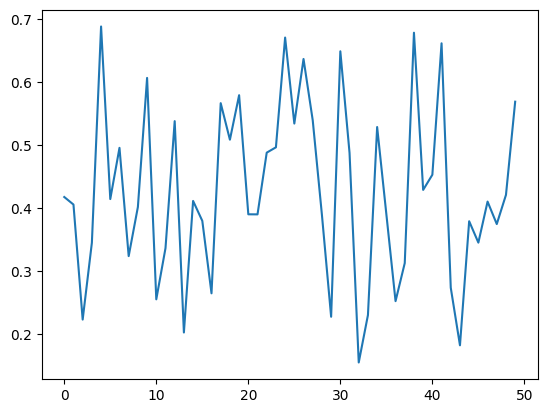

In [ ]:
fig, axes = plt.subplots()
axes.plot(X_train_tensor[0])
plt.show()

**Reconstruction**

Evaluamos la capacidad de reconstrucción del modelo VAE.

In [ ]:
vae.eval()
with torch.no_grad():
  X_train_tensor_autoencoded = vae(X_train_tensor)

In [ ]:
pd.DataFrame(X_train_1).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.414497,0.436574,0.291296,0.431411,0.475245,0.362183,0.448612,0.431139,0.432261,0.462427,...,0.469692,0.417516,0.487172,0.398345,0.454435,0.445945,0.439272,0.461948,0.452851,0.444553
std,0.237220,0.156974,0.154377,0.153228,0.199445,0.162033,0.154158,0.170164,0.136224,0.176935,...,0.196283,0.182105,0.167167,0.183515,0.174675,0.185929,0.189147,0.176074,0.193164,0.195845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.239631,0.344379,0.176729,0.341475,0.332405,0.263642,0.354886,0.310511,0.353625,0.349728,...,0.353166,0.272041,0.388420,0.266693,0.322369,0.326862,0.301880,0.339548,0.349709,0.330691
50%,0.393876,0.445587,0.279116,0.408981,0.493847,0.339102,0.445724,0.406822,0.415847,0.468532,...,0.470801,0.411711,0.486711,0.406516,0.457128,0.437370,0.410166,0.455092,0.427730,0.431817
75%,0.560019,0.529598,0.386808,0.526219,0.617579,0.437462,0.535364,0.548294,0.503173,0.569843,...,0.600038,0.499849,0.576052,0.516470,0.559090,0.558570,0.564793,0.580456,0.590437,0.560731
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
pd.DataFrame(X_train_tensor_autoencoded[0]).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.405998,0.460670,0.325423,0.450787,0.488202,0.364884,0.458153,0.434669,0.431910,0.466340,...,0.489569,0.424617,0.510266,0.408011,0.445881,0.436716,0.443175,0.480638,0.454745,0.467205
std,0.061672,0.039719,0.042418,0.027985,0.050088,0.026095,0.041700,0.044209,0.035075,0.051779,...,0.041419,0.035362,0.046783,0.045612,0.041132,0.041234,0.044476,0.030640,0.045241,0.049691
min,0.258633,0.364080,0.176999,0.349707,0.236105,0.288631,0.334270,0.288001,0.285190,0.328081,...,0.281597,0.317348,0.367652,0.262908,0.314082,0.307582,0.296975,0.402407,0.250177,0.284798
25%,0.360973,0.435012,0.309525,0.439047,0.470094,0.352481,0.432444,0.404471,0.411314,0.429232,...,0.472509,0.402249,0.482846,0.386968,0.425840,0.421828,0.419555,0.460063,0.446460,0.438437
50%,0.397822,0.455188,0.328643,0.451492,0.493351,0.367775,0.461151,0.439153,0.431546,0.467854,...,0.494505,0.423691,0.509053,0.412487,0.445228,0.448097,0.437647,0.478324,0.465873,0.477797
75%,0.441002,0.479775,0.355122,0.470209,0.514778,0.378358,0.484808,0.464403,0.452034,0.499369,...,0.515762,0.450992,0.528512,0.434433,0.470735,0.462344,0.465879,0.497804,0.481672,0.499482
max,0.592503,0.578469,0.411729,0.505669,0.602426,0.446437,0.621024,0.529006,0.521203,0.600152,...,0.582206,0.519601,0.680506,0.535257,0.530223,0.499161,0.585024,0.573604,0.511435,0.567243


Comparamos las gráficas que representan algunas de las instancias originales y su reconstrucción.

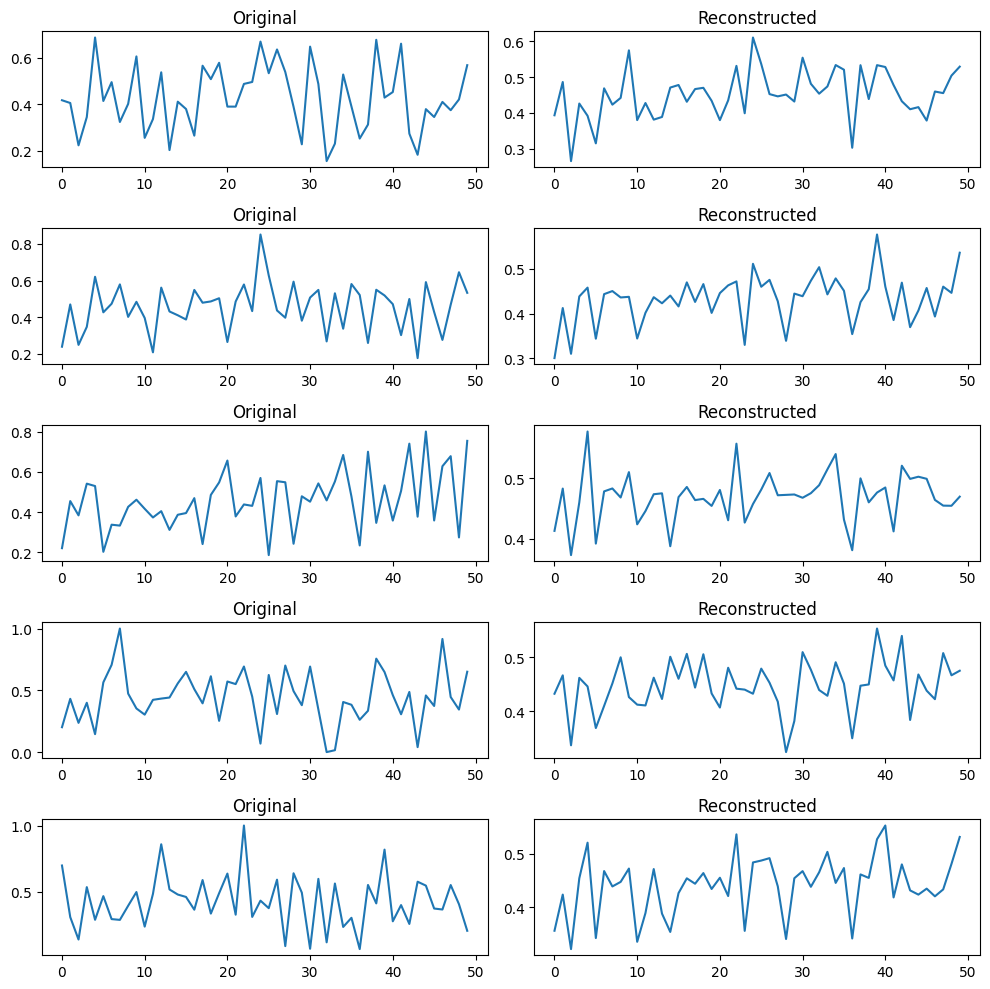

In [ ]:
# Plot some examples of original vs reconstructed
num_examples = 5  # Number of examples to plot
fig, axes = plt.subplots(num_examples, 2, figsize=(10, 10))
for i in range(num_examples):
    axes[i, 0].plot(X_train_tensor[i])
    axes[i, 0].set_title("Original")
    axes[i, 1].plot(X_train_tensor_autoencoded[0][i])
    axes[i, 1].set_title("Reconstructed")

plt.tight_layout()
plt.show()

**Train and test error**

In [ ]:
def recons_error(model, data_loader):
  reconstruction_errors = []
  model.eval()
  with torch.no_grad():
      for batch in data_loader:
          x, _ = batch
          x_hat, _, _ = model(x)
          x = x.numpy()
          x_hat = x_hat.numpy()
          batch_errors = [mean_squared_error(x[i], x_hat[i]) for i in range(len(x))]
          reconstruction_errors.extend(batch_errors)

  # Calculate the average reconstruction error
  avg_recons_error = np.mean(reconstruction_errors)
  return avg_recons_error


In [ ]:
print(f"Average Reconstruction Error (MSE): {recons_error(vae, train_loader)}")

Average Reconstruction Error (MSE): 0.03042372688651085


In [ ]:
print(f"Average Reconstruction Error (MSE): {recons_error(vae, test_loader)}")

Average Reconstruction Error (MSE): 0.0764814019203186


Notar que el error obtenido es ligeramente alto teniendo en cuenta que los datos están en el intervalo $[0,1]$.

**Sample data**

Finalmente, probamos a la generación de datos sintéticos con este modelo.

In [ ]:
X_train_1.shape

(121, 50)

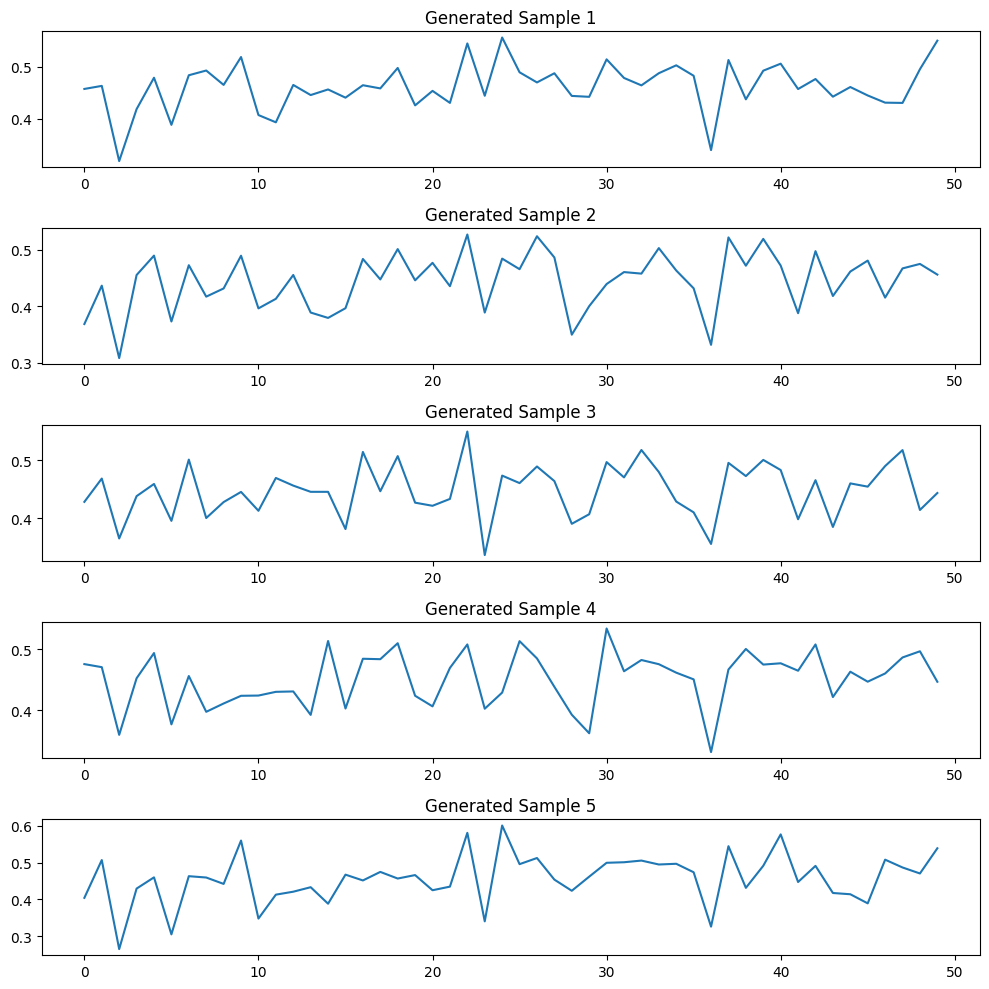

In [ ]:
num_samples = 200

with torch.no_grad():
  generated_samples = vae.sample(num_samples)


# Plot the generated samples
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
for i in range(5):
    axes[i].plot(generated_samples[i])
    axes[i].set_title(f"Generated Sample {i+1}")

plt.tight_layout()
plt.show()


**Classifier**

De la misma forma que en la subsección anterior, usamos como base el clasificador `final_model` para realizar un aprendizaje semi-supervisado.

In [ ]:
X_combined = np.vstack((X_train_1, generated_samples))
y_combined = np.concatenate((y_train, -1 * np.ones(generated_samples.shape[0])))

# Create the self-training classifier
self_training_clf = SelfTrainingClassifier(final_model, threshold=0.85)

# Train the classifier
self_training_clf.fit(X_combined, y_combined)

# Evaluate the classifier on the labeled data (or any test data you have)
accuracy = self_training_clf.score(X_train_1, y_train)
print(f"Accuracy on labeled training data: {accuracy:.4f}")
accuracy = self_training_clf.score(X_test_1, y_test)
print(f"Accuracy on labeled test data: {accuracy:.4f}")

Accuracy on labeled training data: 1.0000
Accuracy on labeled test data: 0.7358


Vemos que de esta manera, se obtiene un accuracy algo peor que únicamente con los datos de entrenamiento base y el modelo supervisado. Esto puede deberse a la falta de generalización del VAE, ya que aunque se hayan introducido medidas de regularización, la falta de datos hace que sea más complejo un buen entrenamiento.

Probamos con otro algoritmo de aprendizaje semi supervisado.

In [ ]:
label_prop_model = LabelPropagation(kernel='knn',n_neighbors=7)

y_train_num = (y_train=='P').astype(int)
y_combined = np.concatenate((y_train_num, -1 * np.ones(generated_samples.shape[0])))
label_prop_model.fit(X_combined, y_combined)

LabelPropagation(kernel='knn')

In [ ]:
label_prop_model.score(X_test_1,(y_test=='P').astype(int))

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


0.6037735849056604

## **GAN**

En esta subsección implementamos un modelo GAN. Dicho modelo consiste de una red neuronal que hace de generador, creando nuevos datos, y una red neuronal con el papel de discriminador, que trata de distinguir qué instancias son reales y cuáles son generadas.

La diferencia de la implementación que vamos a realizar con respecto a un GAN genérico, es que el discriminador, además de distinguir entre instancias reales y falsas, se entrena para que sea capaz de clasificar las instancias, asignando una etiqueta distinta (no son ni Healthy ni Patient) a las instancias sintéticas.

Tras el entrenamiento del modelo, nos podemos quedar con la red discriminadora, que con la implementación dada, nos servirá como modelo para la clasificación.


Referencias:
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

https://towardsdatascience.com/semi-supervised-learning-with-gans-9f3cb128c5e

**Generador**

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim=10):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input un vector de tamaño 10
            nn.Linear(in_features=input_dim, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            # Resultado un vector de tamaño 512

            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            # Resultado un vector de tamaño 256

            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            # Resultado un vector de tamaño 128

            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            # Resultado un vector de tamaño 64

            nn.Linear(in_features=64, out_features=50),
            nn.Sigmoid()
            # Resultado un vector de 50 features

        )


    def forward(self, z):
      return self.main(z)



**Probamos el modelo**

Vemos la arquitectura del generador. Toma un punto de un espacio latente para generar una instancia de 50 características. El objetivo es que las instancias generadas sean similares a las reales, intentando engañar de esta manera al discriminador.

In [ ]:
gen = Generator()
gen

Generator(
  (main): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=64, out_features=50, bias=True)
    (13): Sigmoid()
  )
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)

# Cada instancia debe tener shape (10,1) (espacio latente de dim 10 por defecto)
summary(gen, (10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           5,632
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5                  [-1, 256]             512
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
       BatchNorm1d-8                  [-1, 128]             256
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
      BatchNorm1d-11                   [-1, 64]             128
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 50]           3,250
          Sigmoid-14                   

In [ ]:
random_tensor = torch.tensor(np.random.rand(16,10), dtype=torch.float32)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Sin esto falla
if torch.cuda.is_available():
  gen.cuda()
  random_tensor = random_tensor.cuda()

gen.apply(weights_init)
gen(random_tensor).shape

torch.Size([16, 50])

**Discriminador**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.main = nn.Sequential(
        # Input un tensor de shape 50x1x1
        nn.Linear(in_features=50, out_features=512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(in_features=512, out_features=256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(in_features=256, out_features=128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(in_features=128, out_features=64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        # 3 = num_clases + 1 (para identificar fakes)
        nn.Linear(in_features=64,out_features=3)
    )

    self.classifier = nn.Sequential(
        nn.Softmax()
    )

    self.final_layer = nn.Sequential(
        nn.Linear(in_features=3, out_features=1),
        nn.Sigmoid()
    )


  def forward(self, z):
    z = self.main(z)
    classifier = self.classifier(z)
    gan_out = self.final_layer(z)
    return classifier, gan_out

**Probamos el modelo**

El discriminador toma como entrada un vector 1D de 50 características. Tras hacer cálculos con el, manda el resultado a dos bloques distintos. Uno de ellos es el encargado de decidir si dicha entrada era una instancia real o generada, mientras que el otro bloque se encarga de asignar las probabilidades de clase de la instancia.

In [ ]:
disc = Discriminator()
disc

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
  (classifi

In [ ]:
disc.to(device)

summary(disc, (50,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          26,112
         LeakyReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5                  [-1, 256]             512
         LeakyReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
       BatchNorm1d-9                  [-1, 128]             256
        LeakyReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
      BatchNorm1d-13                   [-1, 64]             128
        LeakyReLU-14                   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
# Sin esto falla
if torch.cuda.is_available():
  disc.cuda()
  X_train_tensor = X_train_tensor.cuda()

disc.apply(weights_init)
disc(X_train_tensor)

(tensor([[0.4168, 0.2532, 0.3299],
         [0.3894, 0.2749, 0.3357],
         [0.2449, 0.2669, 0.4883],
         [0.3874, 0.3389, 0.2737],
         [0.2753, 0.2475, 0.4772],
         [0.2799, 0.1775, 0.5426],
         [0.2457, 0.1881, 0.5662],
         [0.2848, 0.4026, 0.3126],
         [0.2418, 0.4495, 0.3087],
         [0.2638, 0.2799, 0.4563],
         [0.2676, 0.3392, 0.3932],
         [0.3486, 0.1970, 0.4545],
         [0.1772, 0.6271, 0.1957],
         [0.3049, 0.2490, 0.4461],
         [0.3358, 0.4608, 0.2034],
         [0.3603, 0.2601, 0.3796],
         [0.4583, 0.2216, 0.3201],
         [0.2031, 0.3068, 0.4901],
         [0.3221, 0.3514, 0.3265],
         [0.2811, 0.2498, 0.4691],
         [0.5153, 0.1884, 0.2963],
         [0.2243, 0.3734, 0.4023],
         [0.2359, 0.1187, 0.6454],
         [0.1925, 0.3442, 0.4632],
         [0.2462, 0.3827, 0.3711],
         [0.1904, 0.2130, 0.5966],
         [0.2646, 0.4525, 0.2829],
         [0.4260, 0.2151, 0.3589],
         [0.2672, 0.

**Entrenamiento**

In [ ]:
# Convertir etiquetas a tensor si no lo están
y_train_tensor = torch.tensor((y_train=='P').astype(int))

# Convertir a TensorDataset para el DataLoader
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Crear instancias de generador y discriminador
generator = Generator()
discriminator = Discriminator()

# Definir optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Definir función de pérdida para la clasificación
criterion_classifier = nn.CrossEntropyLoss()

num_epochs = 100

In [ ]:
# Función de entrenamiento conjunta
def train_gan(generator, discriminator, dataloader, optimizer_G, optimizer_D, criterion_classifier, num_epochs):
    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move models to the device
    generator.to(device)
    discriminator.to(device)

    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        total_loss_classifier = 0.0
        total_loss_gan = 0.0

        for i, (inputs, labels) in enumerate(dataloader):

            batch_size = inputs.size(0)

            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Entrenamiento del Discriminador
            optimizer_D.zero_grad()

            # Generar imágenes falsas
            z = torch.randn(batch_size, 10, device=device)  # Generar ruido
            fake_images = generator(z).detach()  # Generar imágenes falsas

            real_classifier_output, real_gan_output = discriminator(inputs)
            fake_classifier_output, fake_gan_output = discriminator(fake_images)

            # Calcular pérdida de clasificación
            loss_classifier_real = criterion_classifier(real_classifier_output, labels)
            loss_classifier_fake = criterion_classifier(fake_classifier_output, torch.full_like(labels, 2))  # 'fake' label
            loss_classifier = (loss_classifier_real + loss_classifier_fake) / 2

            # Calcular pérdida adversarial (GAN)
            loss_gan = nn.BCELoss()(real_gan_output.squeeze(), torch.ones(batch_size, device=device)) + \
                       nn.BCELoss()(fake_gan_output.squeeze(), torch.zeros(batch_size, device=device))

            # Pérdida total del discriminador
            loss_D = loss_classifier + 0.0001*loss_gan

            # Backward y optimización
            loss_D.backward()
            optimizer_D.step()

            total_loss_classifier += loss_classifier.item()
            total_loss_gan += loss_gan.item()

            # 2. Entrenamiento del Generador
            optimizer_G.zero_grad()

            # Generar imágenes falsas y pasarlas por el discriminador
            z = torch.randn(batch_size, 10, device=device)  # Generar ruido
            fake_images = generator(z)
            _, gan_output = discriminator(fake_images)

            # Calcular pérdida del generador (GAN)
            loss_G = nn.BCELoss()(gan_output.squeeze(), torch.ones(batch_size, device=device))

            # Backward y optimización
            loss_G.backward()
            optimizer_G.step()

        # Imprimir estadísticas del epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss Clasificación: {total_loss_classifier / len(dataloader):.4f}, '
              f'Loss GAN: {total_loss_gan / len(dataloader):.4f}')

# Llamar a la función de entrenamiento conjunta
train_gan(generator, discriminator, dataloader, optimizer_G, optimizer_D, criterion_classifier, num_epochs)


Epoch [1/100], Loss Clasificación: 1.1137, Loss GAN: 1.3976
Epoch [2/100], Loss Clasificación: 1.0994, Loss GAN: 1.3845
Epoch [3/100], Loss Clasificación: 1.0979, Loss GAN: 1.3980
Epoch [4/100], Loss Clasificación: 1.0815, Loss GAN: 1.3895
Epoch [5/100], Loss Clasificación: 1.0780, Loss GAN: 1.3995
Epoch [6/100], Loss Clasificación: 1.0560, Loss GAN: 1.3848
Epoch [7/100], Loss Clasificación: 1.0481, Loss GAN: 1.3878
Epoch [8/100], Loss Clasificación: 1.0470, Loss GAN: 1.3910
Epoch [9/100], Loss Clasificación: 1.0296, Loss GAN: 1.4000
Epoch [10/100], Loss Clasificación: 1.0083, Loss GAN: 1.3976
Epoch [11/100], Loss Clasificación: 1.0155, Loss GAN: 1.4002
Epoch [12/100], Loss Clasificación: 1.0193, Loss GAN: 1.4013
Epoch [13/100], Loss Clasificación: 1.0056, Loss GAN: 1.3945
Epoch [14/100], Loss Clasificación: 0.9961, Loss GAN: 1.3982
Epoch [15/100], Loss Clasificación: 0.9938, Loss GAN: 1.4059
Epoch [16/100], Loss Clasificación: 0.9799, Loss GAN: 1.3953
Epoch [17/100], Loss Clasificació

In [ ]:
classif_train = discriminator(X_train_tensor)[0]

In [ ]:
classif_train_cpu = classif_train.cpu().detach().numpy()
max_indices = np.argmax(classif_train_cpu, axis=1)

In [ ]:
np.sum(max_indices==(y_train=='P').astype(int))/len(max_indices)

0.9669421487603306

In [ ]:
if torch.cuda.is_available():
  X_test_tensor = X_test_tensor.cuda()

classif_test = discriminator(X_test_tensor)[0]

In [ ]:
classif_test_cpu = classif_test.cpu().detach().numpy()
max_indices_test = np.argmax(classif_test_cpu, axis=1)

In [ ]:
y_test = y_test.values.ravel()  # Convertir el DataFrame de una columna a un vector

In [ ]:
np.sum(max_indices_test==(y_test=='P').astype(int))/len(max_indices_test)

0.6226415094339622

Obtenemos un resultado muy bueno en el conjunto de entrenamiento, pero no tanto en el de test. Esto puede indicar que el modelo no ha sido capaz de generalizar correctamente. Como hemos comentado anteriormente, la escasez de datos no solo da problemas en el cuaderno principal para construir los clasificadores, sino que en estos modelos, también afecta la falta de datos.

# **Modelos preentrenados**

En este apartado final tomamos una aproximación distinta al problema. La idea es tomar una red preentrenada, en este caso, tomamos el modelo ResNet18 (que es usado para clasificación de imágenes) y congelar los parámetros ya añadidos. A continuación, se adapta dicho modelo a nuestro problema, y se entrena únicamente los nuevos parámetros que han sido añadidos al incluir una capa de entrada y salida distintas.

Usar modelos preentrenados es buena idea cuando se tiene un número escaso de instancias de entrenamiento, ya que estos vienen ya con pesos aprendidos.

## **ResNet18**

In [ ]:
model = models.resnet18(pretrained=True)

# Congelamos los parámetros preentrenados
for param in model.parameters():
    param.requires_grad = False

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cambiamos la última capa para que la salida sea un valor real y aplicamos una función sigmoide, de esta manera, podemos hacer clasificación binaria con el modelo.

Además, añadimos a la entrada una convolución compuesta, con la que transformamos nuestro vector 1D de 50 características en una matriz compatible con la red ResNet18.

In [ ]:
num_feat = model.fc.in_features
model.fc = nn.Linear(num_feat, 1)

model = nn.Sequential(
    nn.ConvTranspose2d(in_channels=50,out_channels=3,kernel_size=32,stride=1,padding=0,bias=False),
    model,
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): ConvTranspose2d(50, 3, kernel_size=(32, 32), stride=(1, 1), bias=False)
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
model.to(device)
summary(model, (50,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 3, 32, 32]         153,600
            Conv2d-2           [-1, 64, 16, 16]           9,408
       BatchNorm2d-3           [-1, 64, 16, 16]             128
              ReLU-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,864
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
       BasicBlock-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


**Entrenamiento**

In [ ]:
X_train_resnet = X_train_tensor.view(X_train_tensor.size(0),50,1,1)
X_train_resnet = X_train_resnet.to(device)
X_train_resnet.shape

torch.Size([121, 50, 1, 1])

In [ ]:
X_train_resnet, X_val_resnet, y_train_resnet, y_val_resnet = train_test_split(X_train_resnet, y_train_tensor, test_size=0.3, random_state=42)

train_dataset = TensorDataset(X_train_resnet, y_train_resnet)
val_dataset = TensorDataset(X_val_resnet, y_val_resnet)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

for name, param in model.named_parameters():
    if not param.requires_grad:
        param.grad = None

num_epochs = 100
# Initialize variables for early stopping
patience = 10
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device).float().view(-1,1)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)

  epoch_loss = running_loss / len(train_dataloader.dataset)
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

  # Validation phase
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
      for val_inputs, val_labels in val_dataloader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device).float().view(-1, 1)

          val_outputs = model(val_inputs)
          val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)

  val_loss /= len(val_dataloader.dataset)
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

  # Early stopping check
  if val_loss < best_loss:
      best_loss = val_loss
      patience_counter = 0
      # Save the best model
      best_model_weights = model.state_dict()
  else:
      patience_counter += 1
      if patience_counter >= patience:
          print(f'Early stopping at epoch {epoch+1}')
          break

# Load the best model
model.load_state_dict(best_model_weights)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/100, Loss: 0.7654
Epoch 1/100, Loss: 0.7654, Val Loss: 0.9014
Epoch 2/100, Loss: 0.7578
Epoch 2/100, Loss: 0.7578, Val Loss: 1.5394
Epoch 3/100, Loss: 0.6542
Epoch 3/100, Loss: 0.6542, Val Loss: 1.7858
Epoch 4/100, Loss: 0.7005
Epoch 4/100, Loss: 0.7005, Val Loss: 1.5654
Epoch 5/100, Loss: 0.6533
Epoch 5/100, Loss: 0.6533, Val Loss: 1.8179
Epoch 6/100, Loss: 0.6365
Epoch 6/100, Loss: 0.6365, Val Loss: 1.9541
Epoch 7/100, Loss: 0.6581
Epoch 7/100, Loss: 0.6581, Val Loss: 1.9356
Epoch 8/100, Loss: 0.6385
Epoch 8/100, Loss: 0.6385, Val Loss: 2.1930
Epoch 9/100, Loss: 0.6249
Epoch 9/100, Loss: 0.6249, Val Loss: 1.1653
Epoch 10/100, Loss: 0.5341
Epoch 10/100, Loss: 0.5341, Val Loss: 0.8845
Epoch 11/100, Loss: 0.5287
Epoch 11/100, Loss: 0.5287, Val Loss: 0.9510
Epoch 12/100, Loss: 0.4946
Epoch 12/100, Loss: 0.4946, Val Loss: 0.8106
Epoch 13/100, Loss: 0.4920
Epoch 13/100, Loss: 0.4920, Val Loss: 0.6670
Epoch 14/100, Loss: 0.4760
Epoch 14/100, Loss: 0.4760, Val Loss: 0.7620
Epoch 15/1

<All keys matched successfully>

In [ ]:
X_test_resnet = X_test_tensor.view(X_test_tensor.size(0),50,1,1).to(device)
y_test_tensor = torch.tensor((y_test=='P').astype(int))
y_test_tensor = y_test_tensor.to(device).float().view(-1,1)

In [ ]:
model.eval()

with torch.no_grad():
  outputs = model(X_test_resnet)
  preds = (outputs >= 0.5).float()

preds = preds.cpu().numpy()
y_test_tensor = y_test_tensor.cpu().numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_tensor, preds)
precision = precision_score(y_test_tensor, preds)
recall = recall_score(y_test_tensor, preds)
f1 = f1_score(y_test_tensor, preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5472
Precision: 0.5319
Recall: 0.9259
F1 Score: 0.6757


Obtenemos un accuracy de aproximadamente 0.55. Esto nos indica que el modelo no ha conseguido un buen porcentaje de clasificación en test.

# Conclusiones
En este estudio surgen los mismos problemas que en el cuaderno principal. La escasez de datos hace que el entrenamiento de modelos complejos no consiga buenos resultados. Como consecuencia, los datos sintéticos generados no van a ser lo suficientemente buenos como para mejorar la clasificación supervisada realizada con el modelo base. De hecho, únicamente se consigue mejora al generar "nuevas" instancias añadiendo ruido aleatorio, enfoque para el cual no ha sido necesario el entrenamiento de ninguna red neuronal.

Como futuros trabajos, se propone un exhaustivo ajuste de hiperparámetros de las redes neuronales de VAE y GAN con el objetivo de reducir el error de generalización, y obtener así unos buenos resultados para la clasificación.